In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.porter import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
df = pd.read_csv("C:/Users/mikec/Documents/davidson/data/labeled_data.csv")

In [3]:
tweets=df.tweet

In [4]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

C:\Users\mikec\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [7]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [8]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [9]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [10]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [11]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [12]:
feats = get_feature_array(tweets)

In [13]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [14]:
M.shape

(24783, 11172)

In [15]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [16]:
X = pd.DataFrame(M)
y = df['class'].astype(int)
X.columns = feature_names

In [17]:
#Feature selection 
from sklearn.feature_selection import SelectKBest, f_classif
# Univariate Selection -- apply SelectKBest class to extract top n best features
bestfeatures = SelectKBest(score_func=f_classif, k=3000)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print('Univariate Selection features found, use getUnivariateData() to get the features')
# Extract the top n features
uni_selected_feat = featureScores.nlargest(3000,'Score')
print(uni_selected_feat) # print out the top n features selected
# Saving the top n features to a data frame
top_univariate_features = pd.DataFrame()
for i in range(0, 3000):
    curr_column_vals = X.iloc[:, uni_selected_feat.iloc[i].name]
    curr_column_name = uni_selected_feat.iloc[i][0]
    top_univariate_features[curr_column_name] = curr_column_vals
X = top_univariate_features

Univariate Selection features found, use getUnivariateData() to get the features
                  Specs        Score
535               bitch  2384.592874
11164         vader neg  1772.135115
11166         vader neu  1384.101505
11167    vader compound  1350.379776
2002             faggot   903.795790
6305              trash   852.094597
512                bird   824.433547
6998              yanke   648.175049
4394             nigger   643.049468
11156               FRE   600.180045
1209             charli   589.646341
11158  avg_syl_per_word   515.689760
11155              FKRA   497.458888
2916                hoe   483.474357
7029             yellow   432.872647
2000                fag   301.480469
11170          num_urls   294.387789
4901              pussi   266.527970
6828        white trash   254.230504
6818              white   253.601431
2246               fuck   226.482701
4573               oreo   213.074922
1047             browni   206.540573
3323             jihadi   201.8

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)


In [20]:
from imblearn.under_sampling import RandomUnderSampler
print("Random Under Sampler!!")
rus = RandomUnderSampler(random_state=2)
X_res, y_res = rus.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_res)
X_train.columns = uni_selected_feat['Specs']
y_train = pd.DataFrame()
y_train['labels'] = y_res
print("Done!")


Using TensorFlow backend.


Random Under Sampler!!
Done!


In [21]:
#y_train = y_train.to_frame(name='labels')
y_test = y_test.to_frame(name='labels')

In [22]:
X_train.to_csv('C:/Users/mikec/Documents/X_train.csv', index=None, header=True, encoding='utf-8')
X_test.to_csv('C:/Users/mikec/Documents/X_test.csv', index=None, header=True, encoding='utf-8')
y_train.to_csv('C:/Users/mikec/Documents/y_train.csv', index=None, header=True, encoding='utf-8')
y_test.to_csv('C:/Users/mikec/Documents/y_test.csv', index=None, header=True, encoding='utf-8')

In [23]:
import h2o
h2o.init()
from h2o.automl import H2OAutoML

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.211-b12, mixed mode)
  Starting server from C:\Users\mikec\AppData\Local\Programs\Python\Python37\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\mikec\AppData\Local\Temp\tmpajv5khsm
  JVM stdout: C:\Users\mikec\AppData\Local\Temp\tmpajv5khsm\h2o_mikec_started_from_python.out
  JVM stderr: C:\Users\mikec\AppData\Local\Temp\tmpajv5khsm\h2o_mikec_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 17 days
H2O cluster name:,H2O_from_python_mikec_ap2mdz
H2O cluster total nodes:,1
H2O cluster free memory:,1.752 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [24]:
X_train = h2o.import_file('C:/Users/mikec/Documents/X_train.csv')
y_train = h2o.import_file('C:/Users/mikec/Documents/y_train.csv')
X_test = h2o.import_file('C:/Users/mikec/Documents/X_test.csv')
y_test = h2o.import_file('C:/Users/mikec/Documents/y_test.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
# preparing the train and test data sets
# now convert tweet vecs and labels to a pandas dataframe and back to h2o dataframe
train = X_train.cbind(y_train)
test = X_test.cbind(y_test)

In [26]:
# more on data prep
x = train.columns         # x: A list/vector of predictor column names or indexes. 
                          # This argument only needs to be specified if the user wants to exclude columns from the 
                          # set of predictors. If all columns (other than the response) should be used in prediction, 
                          # then this does not need to be set.

y = "labels"              # This argument is the name (or index) of the response column
x.remove(y)

# need to set train and test
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [27]:
# now the AUTO-ML piece comes in
aml = H2OAutoML(max_runtime_secs=3600) #max_models=10 or 20?, max_runtime_secs=3600
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [28]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_AutoML_20190805_150609,0.186414,0.486843,0.389524,0.151729
StackedEnsemble_BestOfFamily_AutoML_20190805_150609,0.189573,0.493696,0.393457,0.154808
GBM_1_AutoML_20190805_150609,0.205371,0.538129,0.414725,0.171996
GBM_2_AutoML_20190805_150609,0.206688,0.54346,0.417568,0.174363
GBM_4_AutoML_20190805_150609,0.209057,0.543646,0.417675,0.174452
GBM_3_AutoML_20190805_150609,0.212744,0.544919,0.418091,0.1748
GBM_grid_1_AutoML_20190805_150609_model_1,0.234334,0.663151,0.479341,0.229768
GLM_grid_1_AutoML_20190805_150609_model_1,0.235914,0.622762,0.45417,0.20627
XRT_1_AutoML_20190805_150609,0.23881,0.799539,0.547022,0.299233
DRF_1_AutoML_20190805_150609,0.248552,0.754721,0.525344,0.275986


In [29]:
lb_pd = lb.as_data_frame()

In [30]:
# The leader model is stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190805_150609
No model summary for this model


ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.05793710710381947
RMSE: 0.24070128189068596

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.15172930716099325
RMSE: 0.3895244628530964


In [31]:
preds = aml.predict(test)
print(preds)

stackedensemble prediction progress: |████████████████████████████████████| 100%



predict,p0,p1,p2
1,0.0839297,0.906573,0.00949697
1,0.0845078,0.90133,0.0141619
2,0.0590234,0.0641893,0.876787
0,0.727311,0.24163,0.0310595
1,0.218404,0.764504,0.0170928
1,0.0824216,0.907814,0.00976403
1,0.0636271,0.928987,0.0073862
1,0.253472,0.737798,0.00872996
1,0.055123,0.93816,0.00671719
1,0.0501487,0.942301,0.00755033


In [32]:
var = preds["predict"].cbind(test[y])
print(var)

predict,labels
1,1
1,1
2,2
0,1
1,1
1,1
1,1
1,1
1,1
1,1


              precision    recall  f1-score   support

           0       0.32      0.78      0.45       164
           1       0.98      0.82      0.89      1905
           2       0.79      0.91      0.84       410

    accuracy                           0.83      2479
   macro avg       0.69      0.84      0.73      2479
weighted avg       0.90      0.83      0.86      2479

[[ 128   26   10]
 [ 248 1567   90]
 [  30    7  373]]
0.8342073416700282
0.8565556741563435


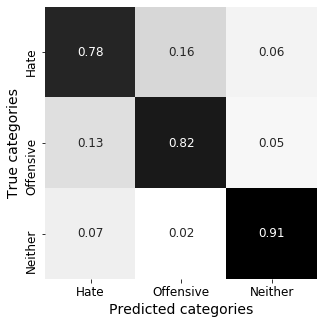

In [33]:
# convert to pandas dataframe
y_test = h2o.as_list(test[y], use_pandas=True)
y_pred = h2o.as_list(preds["predict"])
report = classification_report(y_test, y_pred)
print(report)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)
plt.savefig('C:/Users/mikec/Documents/Results/Univariate3000RandomMax1.png')

f = open("C:/Users/mikec/Documents/Results/Univariate3000RandomMax1.txt", "a")
print("Univariate feature selection with 3000 features with random under sampling, max run time 1 hour", file=f)
print(report, file=f)
print(metrics.confusion_matrix(y_test, y_pred), file=f)
print(metrics.accuracy_score(y_test, y_pred), file=f)
print(metrics.f1_score(y_test, y_pred, average='weighted'), file=f)
f.close()

In [34]:
file = lb_pd.to_csv('C:/Users/mikec/Documents/Results/Univariate3000RandomMax1.csv')
featuresSelected = uni_selected_feat.to_csv('C:/Users/mikec/Documents/Results/feature_selection.csv')